# Project: Write an Algorithm for Distracted Driver Detection 

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

In [21]:
import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

<a id="step0"></a>
## Import Datasets

### Import Driver Dataset

In the following code cell, we create a instance of ImageDataGenerator which does all preprocessing operations on images that we are going to feed to our CNN

In [22]:
train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.2)


In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [23]:
train_data = '../input/state-farm-distracted-driver-detection/imgs/train'
test_data = '../input/state-farm-distracted-driver-detection/imgs/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [24]:
from PIL import Image

ac_labels=  ["c0: safe driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]


In [25]:
imgs, labels = next(train_generator)

## Dataset Exploration
- Following code block explores and reveals the dataset

In [26]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir( os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir,fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ",functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

## Data Visualization
Following code block. displays images and their respective labels of training/ validation dataset

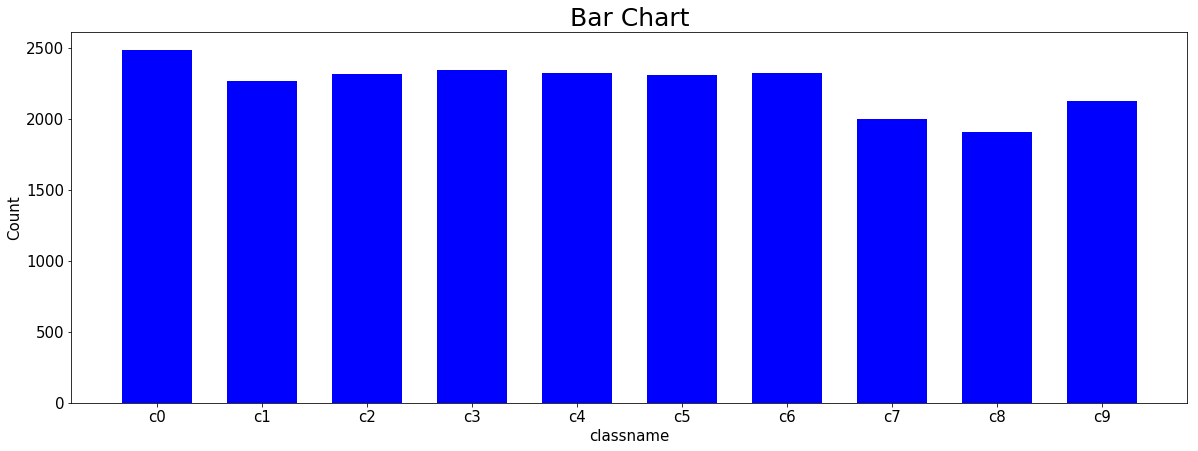

Label :  c0: safe driving


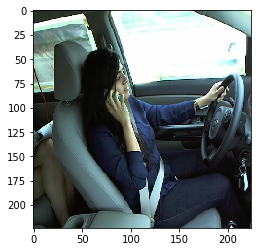

In [27]:

import matplotlib.pyplot as plt
import pandas as pd
# Pretty display for notebooks
%matplotlib inline


y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()



def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 1
showImages(imgs[:ind], inlabels=labels[:ind], single = False)


---
<a id='step1'></a>
## Create a CNN to Classify Driver Images 



A CNN is created to classify driver images.  At the end of the code cell block, the layers of the model are summarized by executing the line:
    
        model.summary()

We have created 6 convolutional layers with 1 max pooling layer and 1 GlobalAveragePooling in between. Filters were increased from 8 to 512 in total convolutional layers. Also dropout was used along with Global average pooling layer before using the fully connected layer. Number of nodes in the last fully connected layer were setup as 10 along with softmax activation function. ReLU activation function was used for all other layers.

6 convolutional layers were used to learn hierarchy of high level features. Max pooling layer is added to reduce the dimensionality. Global Average Pooling layer is added to reduce the dimensionality as well as the matrix to row vector. This is because fully connected layer only accepts row vector. Dropout layers were added to reduce overfitting and ensure that the network generalizes well. The last fully connected layer with softmax activation function is added to obtain probabilities of the prediction.


In [28]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [29]:
input_layer = Input(shape=(224,224, 3))

conv = Conv2D(filters=8, kernel_size=2)(input_layer)
conv = Conv2D(filters=16, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=32, kernel_size=2, activation='relu')(conv)
conv = MaxPooling2D()(conv)

conv = Conv2D(filters=64, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=128, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=512, kernel_size=2, activation='relu')(conv)

conv = GlobalAveragePooling2D()(conv)
dense = Dense(units=500, activation='relu')(conv)
dense = Dropout(0.1)(dense)
dense = Dense(units=100, activation='relu')(dense)
dense = Dropout(0.1)(dense)
output = Dense(units=10, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs = output)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 223, 223, 8)       104       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 222, 222, 16)      528       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 221, 221, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      8256      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 128)     32896     
__________

### Compile CNN from scratch Model

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.


In [32]:
#model.load_weights('best_model_1.hdf5')
checkpoint = ModelCheckpoint('best_model_1.hdf5', save_best_only=True, verbose=1)

history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                    epochs=10,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                    callbacks=[checkpoint] )

Epoch 1/10
561/561 [==============================] - 198s 353ms/step - loss: 2.3014 - acc: 0.1076 - val_loss: 2.2998 - val_acc: 0.1109

Epoch 00001: val_loss improved from inf to 2.29984, saving model to best_model_1.hdf5
Epoch 2/10
561/561 [==============================] - 194s 347ms/step - loss: 2.2904 - acc: 0.1158 - val_loss: 2.2613 - val_acc: 0.1000

Epoch 00002: val_loss improved from 2.29984 to 2.26128, saving model to best_model_1.hdf5
Epoch 3/10
561/561 [==============================] - 194s 346ms/step - loss: 2.0951 - acc: 0.1859 - val_loss: 1.9266 - val_acc: 0.2160

Epoch 00003: val_loss improved from 2.26128 to 1.92664, saving model to best_model_1.hdf5
Epoch 4/10
561/561 [==============================] - 195s 348ms/step - loss: 1.8936 - acc: 0.2289 - val_loss: 1.7801 - val_acc: 0.2615

Epoch 00004: val_loss improved from 1.92664 to 1.78014, saving model to best_model_1.hdf5
Epoch 5/10
561/561 [==============================] - 196s 349ms/step - loss: 1.7475 - acc: 0.28

- In the following code block, we are plotting the loss value of training and validation to see whether the model is learning or not

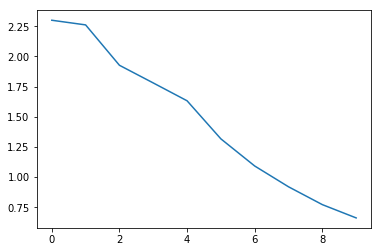

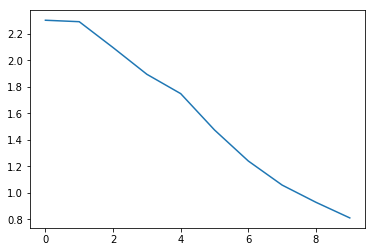

In [33]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

#### Loading test dataset into memory and predict on test images
- Following code block contains a method, that loads all test images into memory by batches, each batch with 32 images when it is called each time

In [34]:

!ls ../input/state-farm-distracted-driver-detection/
import os
# model.load_weights('../input/best_model_1.hdf5')
#Test Images
batch_index = 0
files_list = os.listdir("../input/state-farm-distracted-driver-detection/imgs/test/")
def load_test_images(batch_size=32, src='../input/state-farm-distracted-driver-detection/imgs/test/'):
    global batch_index, files_list
    imgs_list = files_list[batch_index: batch_index+batch_size]
    batch_index += len(imgs_list)
    batch_imgs = []
    for img_name in imgs_list:
        img = Image.open(src+img_name)
        im = img.resize((224,224))
        batch_imgs.append(np.array(im)/255.)
#     plt.imshow()
#     plt.show()
    return np.array(batch_imgs)


driver_imgs_list.csv  imgs  sample_submission.csv


- Following code block predicts on test images by loading 32 images a batch using load_test_images function

In [35]:
#Test Images write
import sys
preds_list = np.array([])
batch_index=0
batch_size = 32
while True:
    tst_imgs = load_test_images(batch_size=batch_size)
    if(tst_imgs.shape[0] <= 0  ):
        print("Batchsize is less : ",batch_index)
        break
    preds = model.predict(tst_imgs)
    print("\r {},  batch_size : {}, nth_batch/all_batch : {}/{}".format(preds_list.shape,batch_size, batch_index, len(files_list)),end="")    
    sys.stdout.flush()
    if len(preds_list) == 0:
        preds_list = np.array(preds)
    else:
        preds_list = np.append(preds_list, preds, axis=0)


 (79712, 10),  batch_size : 32, nth_batch/all_batch : 79726/79726Batchsize is less :  79726


## Convert the predicted output to submittable output file

In [36]:
titles = "img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(",")
names = pd.DataFrame(files_list[:len(preds_list)])
names.columns=["img"]
df = pd.DataFrame(preds_list)
df.columns=titles[1:]
df['img']=names['img']
df = df[titles]
df.tail()
df.to_csv('sub.csv',index=False)


## Predictions by CNN on some sample images

label :  c5: operating the radio


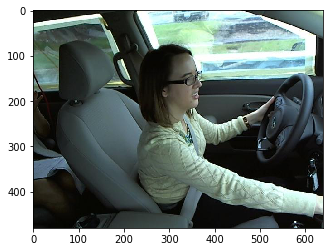

label :  c8: hair and makeup


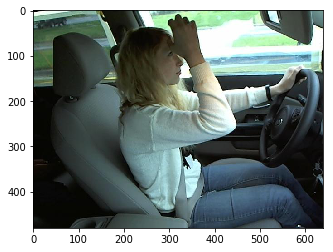

In [37]:
indices = [1,24]
for index in indices:
#     display(df.iloc[index])
    cls = np.argmax(list(df.iloc[index][1:]))
    print("label : ",ac_labels[cls])
    im_test = Image.open('../input/state-farm-distracted-driver-detection/imgs/test/'+df.iloc[index]['img'])
    plt.imshow(np.array(im_test))
    plt.show()